# Modules

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, date, time
import seaborn as sns
from scipy import stats
import scipy.stats as st
import glob

# Dataset

The dataset used in this analysis consists of beer reviews from two beer rating websites,**BeerAdvocate** and **RateBeer**, for a period ranging from 2001 to 2017. For each website, we have 5 files:
- users.csv: metadata about reviewers
- beers.csv : metadata about reviewed beers
- breweries.csv : metadata about breweries
- ratings.txt : all reviews given by users, including numerical ratings and sometimes textual reviews
- reviews.txt : only reviews given by users that include both numerical ratings and textual reviews

In our analysis, we will not use textual reviews. Thus, we will only use ratings.txt files and not reviews.txt files, as we will use all reviews, whether or not they include textual reviews.

### Load data into Dataframes

The .csv files are not too large and can efficiently be loaded into DataFrames.

In [2]:
BA_DATA_FOLDER = 'data/BeerAdvocate/'
RB_DATA_FOLDER = 'data/RateBeer/'

BA_USERS = BA_DATA_FOLDER+"users.csv"
BA_BEERS = BA_DATA_FOLDER+"beers.csv"
BA_BREWERIES = BA_DATA_FOLDER+"breweries.csv"

RB_USERS = RB_DATA_FOLDER+"users.csv"
RB_BEERS = RB_DATA_FOLDER+"beers.csv"
RB_BREWERIES = RB_DATA_FOLDER+"breweries.csv"

In [3]:
ba_users = pd.read_csv(BA_USERS)
ba_beers = pd.read_csv(BA_BEERS)
ba_breweries = pd.read_csv(BA_BREWERIES)

rb_users = pd.read_csv(RB_USERS)
rb_beers = pd.read_csv(RB_BEERS)
rb_breweries = pd.read_csv(RB_BREWERIES)

On the other hand, the ratings.txt files are extremely large, and trying to load them directly into DataFrames leads to kernel freezes. In order to circumvent this problem, we wrote a script (review_parser.py, located in src/scripts), which processes each rating file by dividing it into parts, parsing each part, and saving as JSON. In the notebook, we then load the different JSON files into DataFrames, that we concatenate. Dividing the large .txt files into smaller JSON chunks and then loading each chunk separately, avoids trying to load the entire file into memory at once, which can cause kernel freezes due to memory overload. In addition, JSON is a format that pandas can read efficiently.

In [4]:
# Load BeerAdvocate ratings stored in json files into a single DataFrame
ba_json_files = glob.glob(BA_DATA_FOLDER+'*.json')
ba_df_list = [pd.read_json(file) for file in ba_json_files]
ba_ratings = pd.concat(ba_df_list, ignore_index=True)
ba_ratings.head()

C:\Users\abdul\AppData\Local\Temp\ipykernel_14492\3299018877.py:3: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  ba_df_list = [pd.read_json(file) for file in ba_json_files]
C:\Users\abdul\AppData\Local\Temp\ipykernel_14492\3299018877.py:3: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  ba_df_list = [pd.read_json(file) for file in ba_json_files]


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67
2,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73
3,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98
4,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00


In [5]:
# Load RateBeer ratings stored in json files into a single DataFrame
rb_json_files = glob.glob(RB_DATA_FOLDER+'*.json')
rb_df_list = [pd.read_json(file) for file in rb_json_files]
rb_ratings = pd.concat(rb_df_list, ignore_index=True)
rb_ratings.head()

C:\Users\abdul\AppData\Local\Temp\ipykernel_14492\180671459.py:3: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  rb_df_list = [pd.read_json(file) for file in rb_json_files]
C:\Users\abdul\AppData\Local\Temp\ipykernel_14492\180671459.py:3: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  rb_df_list = [pd.read_json(file) for file in rb_json_files]


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
0,33 Export (Gabon),410549.0,Sobraga,3198.0,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852.0,2.0,4.0,2.0,4.0,8.0,2.0
1,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761.0,2.0,3.0,2.0,4.0,8.0,1.9
2,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2016-06-24 10:00:00,Sibarh,288889.0,3.0,3.0,2.0,3.0,5.0,1.6
3,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2016-01-01 11:00:00,fombe89,250510.0,4.0,3.0,1.0,2.0,5.0,1.5
4,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778.0,2.0,4.0,2.0,4.0,7.0,1.9


### First look at the data

We will now examine the different DataFrames in more detail.

In [6]:
# explain the columns of users, beers, breweries and ratings DataFrames

**BeerAdvocate beer Dataframe**

In [7]:
ba_beers.sample(4)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
122343,830,He'Brew Messiah Stout,262,Shmaltz Brewing Company,American Stout,12,12,3.57,83.0,81.0,NaN,3.571667,NaN,0,NaN
156120,177696,Scratch Beer 196 - 2015 (White Ale),694,Tröegs Brewing Company,Witbier,16,2,4.00,85.0,NaN,5.2,3.713750,NaN,0,NaN
11587,103151,Big Slice Watermelon Wheat,33061,Jing-A (京A) Brewing Co.,Fruit / Vegetable Beer,1,0,4.25,NaN,NaN,4.5,4.250000,0.671871,0,NaN
240451,50477,Amber Dawn,63,Deschutes Brewery,American Amber / Red Ale,2,1,3.07,NaN,NaN,4.9,3.140000,NaN,0,NaN


Let us explain the different columns of the BeerAdvocate beer Dataframe, in which each row is a beer:
- beer_id, beer_name, brewery_id, brewery_name, style are explicit
- nbr_ratings: total number of reviews for that beer, whether or not they include textual reviews
- nbr_reviews: number of reviews for that beer that include textual reviews
- avg: average rating (out of 5) given to the beer based on user ratings
- ba_score: the BeerAdvocate score assigned to the beer, which corresponds to the beer's overall rating within its style category, calculated using a trimmed mean and a custom Bayesian formula that adjusts for the beer's style, balancing the score based on the number of ratings and the style's average
- bros_score: beer rating given by the site’s founders
- abv: 'Alcohol by volume', which indicates the percentage of alcohol content in the beer
- avg_computed: average rating (out of 5) recalculated using a weighted sum of the different aspect ratings
- zscore: z-score of the beer's average rating, which is a statistical measure that indicates how many standard deviations the average rating is from the mean of all ratings from the BeerAdvocate dataset
- nbr_matched_valid_ratings: number of valid ratings for beers that were successfully matched between two BeerAdvocate and RateBeer
- avg_matched_valid_ratings: average rating of those matched and valid ratings across the sites

The last two columns are related to the analysis performed by Robert West and Gael Lederrey in the following paper: https://dlab.epfl.ch/people/west/pub/Lederrey-West_WWW-18.pdf.

**RateBeer beer Dataframe**

In [8]:
rb_beers.sample(4)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
121987,418798,Katjelam Old Man,20750,Nevel Artisan Ales,Saison,8,NaN,NaN,3.23,5.6,3.375000,NaN,0,NaN
195838,462490,Paradise Creek Arc Flash ISA,12166,Paradise Creek Brewery,Session IPA,0,NaN,NaN,NaN,4.1,NaN,NaN,0,NaN
304439,216444,Mimbres Valley Beer Goggles,12599,Mimbres Valley Brewing Company,Pale Lager,2,NaN,NaN,2.79,NaN,2.900000,NaN,0,NaN
164384,287534,Beachwood SADIE,13042,Beachwood BBQ & Brewing,American Strong Ale,36,99.0,97.0,3.84,12.0,3.933333,0.924648,36,3.933333


Let us explain the different columns of the RateBeer beer Dataframe, in which each row is a beer:

The beer_id, beer_name, brewery_id, brewery_name, style, nbr_ratings, avg, abv, avg_computed, z-score, nbr_matched_valid_ratings and avg_matched_valid_ratings are the same as for the BeerAdvocate beer Dataframe.

Some columns are missing compared to the BeerAdvocate beer Dataframe: ba_score and bros_score (which makes sense as these are BeerAdvocate-specific scores), and nbr_reviews.

New columns are present compared to the BeerAdvocate beer Dataframe:
- overall_score: score (out of 100) which "reflects the rating given by RateBeer users and how this beer compares to all other beers on RateBeer", calculated by considering the ratings given by each user and the total number of ratings for the beer
- style_score: score given to the beer (out of 100) specifically within its style category

**BeerAdvocate user Dataframe**

In [9]:
ba_users.sample(4)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
10724,139,98,davideddie.88281,DavidEddie,1.152698e+09,"United States, Illinois"
98976,13,11,adnauseam007.764911,adnauseam007,1.384772e+09,"United States, Illinois"
75016,3,0,hurricaneike85.824867,Hurricaneike85,1.405246e+09,"United States, Texas"
131792,1,1,molly701.622828,Molly701,1.317463e+09,"United States, North Dakota"


Let us explain the different columns of the BeerAdvocate user Dataframe, in which each row is a reviewer:
- nbr_ratings, nbr_reviews, user_id, user_name, and location are explicit
- joined: timestamp indicating when the user joined BeerAdvocate in Unix timestamp format (the number of seconds since January 1, 1970, 00:00:00 UTC)

**RateBeer user Dataframe**

In [10]:
rb_users.sample(4)

,nbr_ratings,user_id,user_name,joined,location
2168,3,14726,squatter,1.093428e+09,New Zealand
11961,79,111679,Signalwriter,1.281780e+09,"United States, Texas"
41972,81,103331,whatsupstairs,1.268824e+09,"United States, California"
3167,65,326599,lbcgreg,1.405505e+09,Canada


Let us explain the different columns of the RateBeer user Dataframe, in which each row is a reviewer:

The columns are the same as in the BeerAdvocate user Dataframe (joined is obviously the timestamp indicating when the user joined RateBeer and not BeerAdvocate), except that nbr_reviews is missing.

**Brewery Dataframes**

In [11]:
ba_breweries.sample(4)

,id,location,name,nbr_beers
4225,5723,Germany,Brauerei Andreas Sauer,0
16625,3816,"United States, Texas",Brenham Brewing Company,3
8376,30377,"United States, California",Oak Hills Brewing Co.,20
6312,32771,Austria,Brauerei Ebner,0


In [12]:
rb_breweries.sample(4)

,id,location,name,nbr_beers
14639,13050,"United States, Washington",Slippery Pig Brewery,49
18692,553,"United States, Michigan",Big Buck Brewery,93
14936,18883,"United States, New Jersey",Angry Erik Brewing,23
5273,2741,Germany,Unionsbräu Haidhausen,4


The columns are explicit and are the same for the 2 websites. Each row is a brewery.

**Rating Dataframes**

In [13]:
ba_ratings.sample(4)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
4272783,Ranger,55081.0,New Belgium Brewing,192.0,American IPA,6.5,2014-01-17 11:00:00,durwood64,durwood64.6640,NaN,NaN,NaN,NaN,NaN,4.25
1428178,Old Rasputin XII,50752.0,North Coast Brewing Co.,112.0,Russian Imperial Stout,11.2,2013-07-05 10:00:00,AlexFields,alexfields.404098,NaN,NaN,NaN,NaN,NaN,3.75
1757297,Beer Camp Across The World: Ginger Lager,281134.0,Sierra Nevada Brewing Co.,140.0,Herbed / Spiced Beer,6.2,2017-06-11 10:00:00,petewheeler,petewheeler.844802,3.75,3.75,3.75,3.75,3.75,3.75
82389,Samuel Smith's Old Brewery Bitter,4074.0,Samuel Smith Old Brewery (Tadcaster),113.0,English Bitter,4.0,2015-11-12 11:00:00,Beerasaurus,beerasaurus.239442,4.00,4.00,4.00,3.50,3.75,3.75


In [14]:
rb_ratings.sample(4)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
1782876,Nova Paka Granát,4854.0,Pivovar Nová Paka,835.0,Polotmavý,5.0,2011-02-13 11:00:00,Christian,7513.0,4.0,6.0,3.0,5.0,12.0,3.0
3593968,Ommegang Hennepin,8837.0,Brewery Ommegang &#40;Duvel-Moortgat&#41;,527.0,Saison,7.7,2009-02-24 11:00:00,Ratman197,18957.0,5.0,6.0,4.0,6.0,13.0,3.4
5726390,Dark Star Sunburst (Cask),16392.0,Dark Star,2824.0,Golden Ale/Blond Ale,4.8,2008-06-28 10:00:00,Doppelganger,15350.0,4.0,7.0,5.0,7.0,15.0,3.8
771188,Sidekick Juicy Lucy,495845.0,Sidekick Brewing,30674.0,Session IPA,4.5,2017-03-28 10:00:00,Borup,41169.0,3.0,7.0,3.0,7.0,14.0,3.4


The columns are the same for the 2 Dataframes. Each row corresponds to an individual review. Most column names are explicit. 
- 'appearance','aroma', 'palate','taste' correspond to aspect ratings (out of 5)
- 'overall' is the mean of the 4 aspect ratings
- 'rating' is the final rating given by the user to the beer

# 0) Data cleaning

In [15]:
# remove useless columns (done)
# make sure each column has the right type (done)
# deal with missing or Nan values (done)
# check the correspondance between brewery_id in the beers DataFrames and brewery_id in the breweries Dataframes (done)
# set all US locations to 'United States' (remove state information) (done)
# remove any embedded HTML links in the location strings (done)
# remove countries with too few reviewers (done)

## Filtering Dataframes

Let us start by removing columns in the different Dataframes that we will not use in our analysis.

The following rows will not be used in our analysis:
nbr_reviews, ba_score, bros_score, abv, avg_computed, zscore, nbr_matched_valid_ratings and avg_matched_valid_ratings, overall_score and style_score.

Let us remove them.

In [16]:
useless_columns_ba = ['nbr_reviews', 'ba_score', 'bros_score', 'abv', 'avg_computed', 'zscore', 'nbr_matched_valid_ratings', 'avg_matched_valid_ratings']
ba_beers = ba_beers.drop(columns=useless_columns_ba)
print(ba_beers.columns)

Index(['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'style',
       'nbr_ratings', 'avg'],
      dtype='object')


In [17]:
useless_columns_rb = [col for col in useless_columns_ba if col not in ['nbr_reviews','ba_score', 'bros_score']] + ['overall_score', 'style_score']
rb_beers = rb_beers.drop(columns=useless_columns_rb)
print(rb_beers.columns)

Index(['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'style',
       'nbr_ratings', 'avg'],
      dtype='object')


We will also not use the timestamps indicating the time when users joined the platforms, so let us remove this as well.

In [18]:
ba_users = ba_users.drop(columns='joined')
rb_users = rb_users.drop(columns='joined')
print(ba_users.columns)

Index(['nbr_ratings', 'nbr_reviews', 'user_id', 'user_name', 'location'], dtype='object')


## Verifying value types

Let us verify that the values in the different columns of the different Dataframes have the appropriate type.

In [19]:
print(ba_beers.dtypes,'\n','\n',rb_beers.dtypes)

beer_id           int64
beer_name        object
brewery_id        int64
brewery_name     object
style            object
nbr_ratings       int64
avg             float64
dtype: object 
 
 beer_id           int64
beer_name        object
brewery_id        int64
brewery_name     object
style            object
nbr_ratings       int64
avg             float64
dtype: object


In [20]:
print(ba_users.dtypes,'\n','\n',rb_users.dtypes)

nbr_ratings     int64
nbr_reviews     int64
user_id        object
user_name      object
location       object
dtype: object 
 
 nbr_ratings     int64
user_id         int64
user_name      object
location       object
dtype: object


In [21]:
print(ba_breweries.dtypes,'\n','\n',rb_breweries.dtypes)

id            int64
location     object
name         object
nbr_beers     int64
dtype: object 
 
 id            int64
location     object
name         object
nbr_beers     int64
dtype: object


In [22]:
columns_to_convert = ['beer_name', 'brewery_name', 'style']

ba_beers[columns_to_convert] = ba_beers[columns_to_convert].apply(lambda col: col.astype(str))
rb_beers[columns_to_convert] = rb_beers[columns_to_convert].apply(lambda col: col.astype(str))
print(ba_beers.dtypes,'\n','\n',rb_beers.dtypes)

beer_id           int64
beer_name        object
brewery_id        int64
brewery_name     object
style            object
nbr_ratings       int64
avg             float64
dtype: object 
 
 beer_id           int64
beer_name        object
brewery_id        int64
brewery_name     object
style            object
nbr_ratings       int64
avg             float64
dtype: object


In [23]:
print(ba_ratings.dtypes,'\n','\n',rb_ratings.dtypes)

beer_name               object
beer_id                float64
brewery_name            object
brewery_id             float64
style                   object
abv                    float64
date            datetime64[ns]
user_name               object
user_id                 object
appearance             float64
aroma                  float64
palate                 float64
taste                  float64
overall                float64
rating                 float64
dtype: object 
 
 beer_name               object
beer_id                float64
brewery_name            object
brewery_id             float64
style                   object
abv                    float64
date            datetime64[ns]
user_name               object
user_id                float64
appearance             float64
aroma                  float64
palate                 float64
taste                  float64
overall                float64
rating                 float64
dtype: object


The types of the values in the different columns of the different Dataframes seem appropriate.

## Dealing with missing values

In [24]:
ba_beers['avg'].value_counts()

avg
4.00    7783
3.75    7059
3.50    5946
3.88    3307
4.25    2871
        ... 
1.14       1
1.19       1
1.04       1
1.05       1
1.27       1
Name: count, Length: 401, dtype: int64

In [25]:
ba_beers

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,avg
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,NaN
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,NaN
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,NaN
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,NaN
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,NaN
...,...,...,...,...,...,...,...
280818,19139,Kölsch Ale,885,Summit Station Restaurant & Brewery,Kölsch,3,2.71
280819,19140,Nut Brown Ale,885,Summit Station Restaurant & Brewery,English Brown Ale,2,3.10
280820,19146,Octoberfest,885,Summit Station Restaurant & Brewery,Märzen / Oktoberfest,0,NaN
280821,2805,Scotch Ale,885,Summit Station Restaurant & Brewery,Scotch Ale / Wee Heavy,0,NaN


In [26]:
ba_beers_cleaned = ba_beers[~pd.isna(ba_beers['avg'])].reset_index(drop=True) # avg = NaN valued beers are removed since there are not any reviews
ba_beers_cleaned

"""
# We are checking if there are beers with 0 averages and remove them:
rows_with_zero_avg = ba_beers_[ba_beers_['avg'] == 0]
#display(rows_with_zero_avg)
ba_beers_ = ba_beers_[ba_beers_['avg'] != 0]
ba_beers_ = ba_beers_.reset_index(drop=True)
# We are checking if there are  beers still left with 0 averages and remove them:
rows_with_zero_ratings=ba_beers_[ba_beers_['nbr_ratings'] == 0]
#display(rows_with_zero_ratings)
ba_beers_cleaned = ba_beers_[ba_beers_['nbr_ratings'] != 0]
ba_beers_cleaned = ba_beers_cleaned.reset_index(drop=True)
#ba_beers_cleaned is the dataset with both columns avg and nbr_ratings purified from the NaN and 0 values-
"""

"\n# We are checking if there are beers with 0 averages and remove them:\nrows_with_zero_avg = ba_beers_[ba_beers_['avg'] == 0]\n#display(rows_with_zero_avg)\nba_beers_ = ba_beers_[ba_beers_['avg'] != 0]\nba_beers_ = ba_beers_.reset_index(drop=True)\n# We are checking if there are  beers still left with 0 averages and remove them:\nrows_with_zero_ratings=ba_beers_[ba_beers_['nbr_ratings'] == 0]\n#display(rows_with_zero_ratings)\nba_beers_cleaned = ba_beers_[ba_beers_['nbr_ratings'] != 0]\nba_beers_cleaned = ba_beers_cleaned.reset_index(drop=True)\n#ba_beers_cleaned is the dataset with both columns avg and nbr_ratings purified from the NaN and 0 values-\n"

In [27]:
rb_beers_cleaned = rb_beers[~pd.isna(rb_beers['avg'])].reset_index(drop=True) # avg = NaN valued beers are removed since there are not any reviews
rb_beers_cleaned

"""
# We are checking if there are beer with 0 ratings and remove them:
#rows_with_zero_ratings_rb=rb_beers_[rb_beers_['nbr_ratings'] == 0]
#display(rows_with_zero_ratings_rb)
rb_beers_ = rb_beers_[rb_beers_['nbr_ratings'] != 0].reset_index(drop=True)

# We are checking if there are beers still left with 0 averages and remove them:
#rows_with_zero_avg_rb = rb_beers_[rb_beers_['avg'] == 0]
#display(rows_with_zero_avg_rb)
rb_beers_cleaned = rb_beers_[rb_beers_['avg'] != 0].reset_index(drop=True)

display(rb_beers_cleaned)

#rb_beers_cleaned is the dataset with both columns avg and nbr_ratings purified from the NaN and 0 values-
"""

"\n# We are checking if there are beer with 0 ratings and remove them:\n#rows_with_zero_ratings_rb=rb_beers_[rb_beers_['nbr_ratings'] == 0]\n#display(rows_with_zero_ratings_rb)\nrb_beers_ = rb_beers_[rb_beers_['nbr_ratings'] != 0].reset_index(drop=True)\n\n# We are checking if there are beers still left with 0 averages and remove them:\n#rows_with_zero_avg_rb = rb_beers_[rb_beers_['avg'] == 0]\n#display(rows_with_zero_avg_rb)\nrb_beers_cleaned = rb_beers_[rb_beers_['avg'] != 0].reset_index(drop=True)\n\ndisplay(rb_beers_cleaned)\n\n#rb_beers_cleaned is the dataset with both columns avg and nbr_ratings purified from the NaN and 0 values-\n"

## Checking the correspondance between brewery_id in the beers DataFrames

In [28]:
rb_beers_cleaned[rb_beers_cleaned['brewery_id'] == 3198]

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,avg
0,410549,33 Export (Gabon),3198,Sobraga,Pale Lager,1,2.72
1,105273,Castel Beer (Gabon),3198,Sobraga,Pale Lager,10,2.18
2,19445,Régab,3198,Sobraga,Pale Lager,27,1.83


In [29]:
rb_breweries[rb_breweries['id'] == 3198]

,id,location,name,nbr_beers
0,3198,Gabon,Sobraga,3


## Removing state information

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
def edit_location(data_name):
    data_name_c = data_name.copy()
    for i in range(len(data_name['location'])):
        if len(data_name['location'][i]) > 10:
            if 'United States' in data_name['location'][i]: # Remove state names
                data_name_c['location'][i] = 'United States'
            elif ',' in data_name['location'][i]:
                data_name_c['location'][i] = data_name['location'][i][:(data_name['location'][i].index(','))] # Removing for the double names ( such as 'United Kingdom,England' )
            elif 'href' in data_name['location'][i]:
                data_name_c.drop(i)
    return data_name_c

In [32]:
ba_breweries_cleaned = edit_location(ba_breweries)
rb_breweries_cleaned = edit_location(rb_breweries)

In [33]:
ba_breweries_cleaned['location']

0           Kyrgyzstan
1           Kyrgyzstan
2           Kyrgyzstan
3           Kyrgyzstan
4           Kyrgyzstan
             ...      
16753          Germany
16754            Aruba
16755    United States
16756    United States
16757    United States
Name: location, Length: 16758, dtype: object

In [34]:
rb_breweries_cleaned['location'].value_counts()

location
United States            6921
England                  2124
Germany                  1999
Italy                    1051
Canada                    884
                         ... 
Sao Tome and Principe       1
Iraq                        1
Micronesia                  1
French Guiana               1
Gabon                       1
Name: count, Length: 217, dtype: int64

## Removing HTML links

In [35]:
# Done above

## Removing the countries who have too few reviewers

In [36]:
ba_users_cleaned = ba_users[~pd.isna(ba_users['location'])].reset_index() # location = NaN valued users are removed
rb_users_cleaned = rb_users[~pd.isna(rb_users['location'])].reset_index() # location = NaN valued users are removed
ba_users_cleaned

,index,nbr_ratings,nbr_reviews,user_id,user_name,location
0,0,7820,465,nmann08.184925,nmann08,"United States, Washington"
1,1,2521,2504,stjamesgate.163714,StJamesGate,"United States, New York"
2,2,1797,1143,mdagnew.19527,mdagnew,Northern Ireland
3,3,31,31,helloloser12345.10867,helloloser12345,Northern Ireland
4,4,604,604,cypressbob.3708,cypressbob,Northern Ireland
...,...,...,...,...,...,...
122420,153698,1,0,eturchick.374415,ETurchick,"United States, California"
122421,153699,1,1,everman.532342,Everman,"United States, California"
122422,153700,1,1,justin0001.352175,Justin0001,"United States, California"
122423,153702,1,1,joetex.800347,JoeTex,"United States, California"


In [37]:
rb_users_cleaned

,index,nbr_ratings,user_id,user_name,location
0,0,1890,175852,Manslow,Poland
1,1,89,442761,MAGICuenca91,Spain
2,2,169,288889,Sibarh,Poland
3,3,3371,250510,fombe89,Spain
4,4,13043,122778,kevnic2008,Germany
...,...,...,...,...,...
50587,70167,1,181614,HaraldS,Norway
50588,70169,1,134893,stamfordbus,England
50589,70170,1,327816,fobia405,Belgium
50590,70172,3,82020,klesidra,Slovenia


In [38]:
ba_users_cleaned_2 = edit_location(ba_users_cleaned)
rb_users_cleaned_2 = edit_location(rb_users_cleaned)

In [39]:
ba_users_cleaned_2

,index,nbr_ratings,nbr_reviews,user_id,user_name,location
0,0,7820,465,nmann08.184925,nmann08,United States
1,1,2521,2504,stjamesgate.163714,StJamesGate,United States
2,2,1797,1143,mdagnew.19527,mdagnew,Northern Ireland
3,3,31,31,helloloser12345.10867,helloloser12345,Northern Ireland
4,4,604,604,cypressbob.3708,cypressbob,Northern Ireland
...,...,...,...,...,...,...
122420,153698,1,0,eturchick.374415,ETurchick,United States
122421,153699,1,1,everman.532342,Everman,United States
122422,153700,1,1,justin0001.352175,Justin0001,United States
122423,153702,1,1,joetex.800347,JoeTex,United States


In [40]:
count = rb_users_cleaned_2['location'].value_counts() < 10 # We have to adjust the thresholds
count[count == True]

location
Andorra               True
Guatemala             True
Faroe Islands         True
Vietnam               True
Dominican Republic    True
                      ... 
Honduras              True
Falkland Islands      True
Kyrgyzstan            True
Papua New Guinea      True
Tibet                 True
Name: count, Length: 100, dtype: bool

In [41]:
#Filters the users from rare locations
remove_rb = rb_users_cleaned_2['location'].isin(count)
rb_users_cleaned_2_copy = rb_users_cleaned_2[~remove_rb].copy()


In [42]:
rb_users_cleaned_2_copy.reset_index(drop=True)

,index,nbr_ratings,user_id,user_name,location
0,0,1890,175852,Manslow,Poland
1,1,89,442761,MAGICuenca91,Spain
2,2,169,288889,Sibarh,Poland
3,3,3371,250510,fombe89,Spain
4,4,13043,122778,kevnic2008,Germany
...,...,...,...,...,...
50587,70167,1,181614,HaraldS,Norway
50588,70169,1,134893,stamfordbus,England
50589,70170,1,327816,fobia405,Belgium
50590,70172,3,82020,klesidra,Slovenia


In [43]:
count2 = ba_users_cleaned_2['location'].value_counts() < 10 # We have to adjust the thresholds
count2[count2 == True]

location
Indonesia                                   True
Luxembourg                                  True
Antarctica                                  True
Uruguay                                     True
Bahamas                                     True
                                            ... 
South Georgia and South Sandwich Islands    True
Angola                                      True
Kazakhstan                                  True
Egypt                                       True
Sint Maarten                                True
Name: count, Length: 84, dtype: bool

In [56]:
#Filters the users from rare locations
remove_ba = ba_users_cleaned_2['location'].isin(count2)
ba_users_cleaned_2_copy = ba_users_cleaned_2[~remove_ba].copy()


In [57]:
ba_users_cleaned_2_copy.reset_index(drop=True)

,index,nbr_ratings,nbr_reviews,user_id,user_name,location
0,0,7820,465,nmann08.184925,nmann08,United States
1,1,2521,2504,stjamesgate.163714,StJamesGate,United States
2,2,1797,1143,mdagnew.19527,mdagnew,Northern Ireland
3,3,31,31,helloloser12345.10867,helloloser12345,Northern Ireland
4,4,604,604,cypressbob.3708,cypressbob,Northern Ireland
...,...,...,...,...,...,...
122420,153698,1,0,eturchick.374415,ETurchick,United States
122421,153699,1,1,everman.532342,Everman,United States
122422,153700,1,1,justin0001.352175,Justin0001,United States
122423,153702,1,1,joetex.800347,JoeTex,United States


# Cleaning the missed values in ratings

In [46]:
ba_ratings[pd.isna(ba_ratings['rating'])]

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
2797677,Ballz Deep Double IPA,53679.0,7 Seas Brewery and Taproom,20658.0,American Double / Imperial IPA,8.4,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5595355,Skillet Donut Stout,96579.0,Burial Beer Co.,31722.0,Oatmeal Stout,8.0,2014-04-20 10:00:00,randylangford,randylangford.227055,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
rb_ratings[pd.isna(rb_ratings['rating'])]

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
2374024,Okocim Mocne,4993.0,Carlsberg Polska,865.0,Imperial Pils/Strong Pale Lager,7.0,2006-08-10 10:00:00,DonMagi,21197.0,2.0,4.0,2.0,NaN,NaN,NaN
4748050,Vermont Pub Silk Ale,10562.0,Vermont Pub & Brewery,641.0,English Pale Ale,4.5,2004-02-06 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
ba_ratings_ = ba_ratings[~pd.isna(ba_ratings['rating'])].reset_index(drop=True)
rb_ratings_ = rb_ratings[~pd.isna(rb_ratings['rating'])].reset_index(drop=True)
display(ba_ratings_)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67
2,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73
3,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98
4,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8393027,Kölsch Ale,19139.0,Summit Station Restaurant & Brewery,885.0,Kölsch,5.0,2006-02-27 11:00:00,jaluria,jaluria.31362,3.50,3.50,3.50,4.00,4.0,3.80
8393028,Kölsch Ale,19139.0,Summit Station Restaurant & Brewery,885.0,Kölsch,5.0,2006-02-19 11:00:00,Dithyramb,dithyramb.4413,3.00,3.00,3.00,2.50,3.0,2.80
8393029,Kölsch Ale,19139.0,Summit Station Restaurant & Brewery,885.0,Kölsch,5.0,2004-08-10 10:00:00,ManekiNeko,manekineko.2654,3.00,1.50,1.00,1.50,1.5,1.54
8393030,Nut Brown Ale,19140.0,Summit Station Restaurant & Brewery,885.0,English Brown Ale,5.3,2012-07-08 10:00:00,Redsox1539,redsox1539.683632,NaN,NaN,NaN,NaN,NaN,3.50


In [49]:
ba_ratings_[pd.isna(ba_ratings_['overall'])]# Let's keep these values since they have the final rating value
display(ba_ratings_)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67
2,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73
3,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98
4,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8393027,Kölsch Ale,19139.0,Summit Station Restaurant & Brewery,885.0,Kölsch,5.0,2006-02-27 11:00:00,jaluria,jaluria.31362,3.50,3.50,3.50,4.00,4.0,3.80
8393028,Kölsch Ale,19139.0,Summit Station Restaurant & Brewery,885.0,Kölsch,5.0,2006-02-19 11:00:00,Dithyramb,dithyramb.4413,3.00,3.00,3.00,2.50,3.0,2.80
8393029,Kölsch Ale,19139.0,Summit Station Restaurant & Brewery,885.0,Kölsch,5.0,2004-08-10 10:00:00,ManekiNeko,manekineko.2654,3.00,1.50,1.00,1.50,1.5,1.54
8393030,Nut Brown Ale,19140.0,Summit Station Restaurant & Brewery,885.0,English Brown Ale,5.3,2012-07-08 10:00:00,Redsox1539,redsox1539.683632,NaN,NaN,NaN,NaN,NaN,3.50


In [50]:
rb_ratings_[pd.isna(rb_ratings_['overall'])] # It seems every rating has in complete form
display(rb_ratings_)


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
0,33 Export (Gabon),410549.0,Sobraga,3198.0,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852.0,2.0,4.0,2.0,4.0,8.0,2.0
1,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761.0,2.0,3.0,2.0,4.0,8.0,1.9
2,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2016-06-24 10:00:00,Sibarh,288889.0,3.0,3.0,2.0,3.0,5.0,1.6
3,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2016-01-01 11:00:00,fombe89,250510.0,4.0,3.0,1.0,2.0,5.0,1.5
4,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778.0,2.0,4.0,2.0,4.0,7.0,1.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7122069,Svejk Blonde,220897.0,Svejk Beer Garden,17155.0,Pale Lager,NaN,2014-09-18 10:00:00,Travlr,83882.0,3.0,6.0,2.0,5.0,10.0,2.6
7122070,Svejk Blonde,220897.0,Svejk Beer Garden,17155.0,Pale Lager,NaN,2013-12-01 11:00:00,TBone,10233.0,2.0,5.0,2.0,6.0,10.0,2.5
7122071,Svejk Dark,220898.0,Svejk Beer Garden,17155.0,Dunkel/Tmavý,NaN,2014-11-04 11:00:00,Rob_D_UK,257161.0,3.0,4.0,2.0,5.0,9.0,2.3
7122072,Svejk Dark,220898.0,Svejk Beer Garden,17155.0,Dunkel/Tmavý,NaN,2014-09-16 10:00:00,Travlr,83882.0,3.0,5.0,1.0,4.0,6.0,1.9


# 1) Link between culture and taste

## a) Beer style preferences

In [51]:
# use clustering techniques to determine beer style is most popular in each country / geographic area
# use time information to determine if regional beer style preferences are stable (which would suggest that they are 
# strongly affected by culture)or if they vary over time

## b) Importance of specific beer attributes

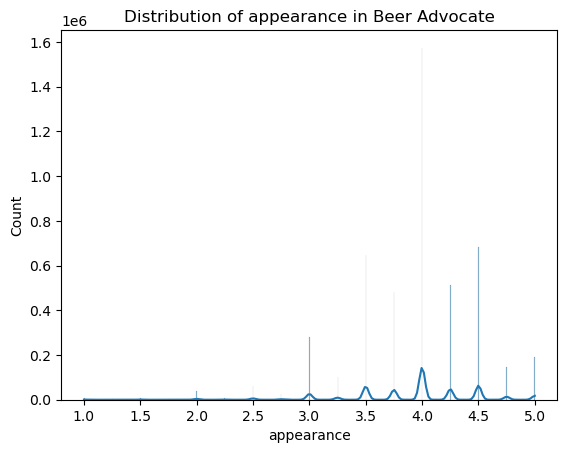

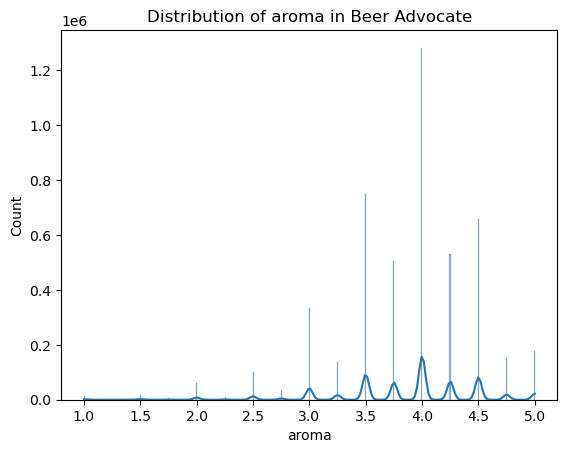

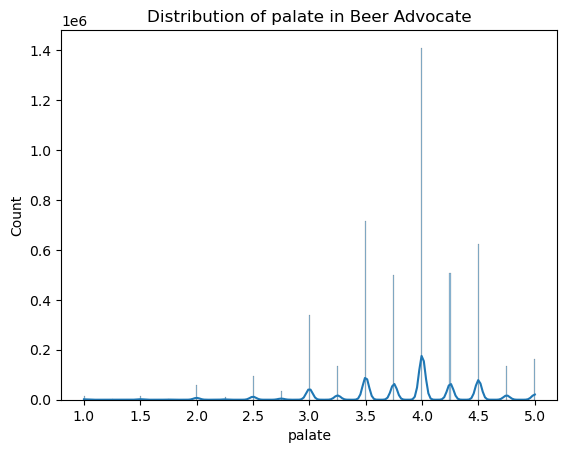

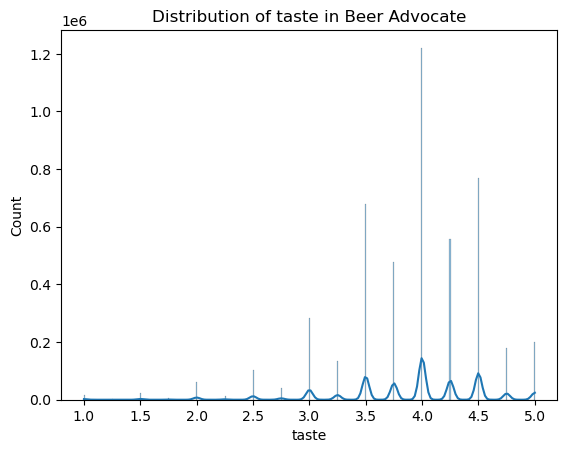

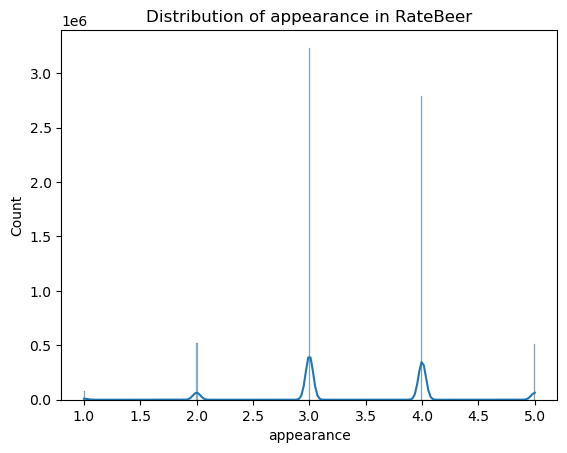

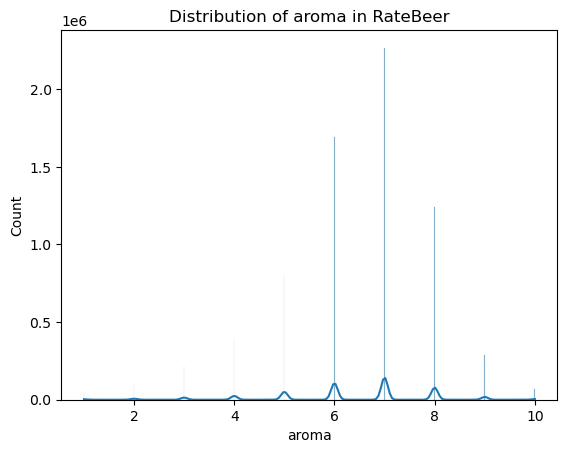

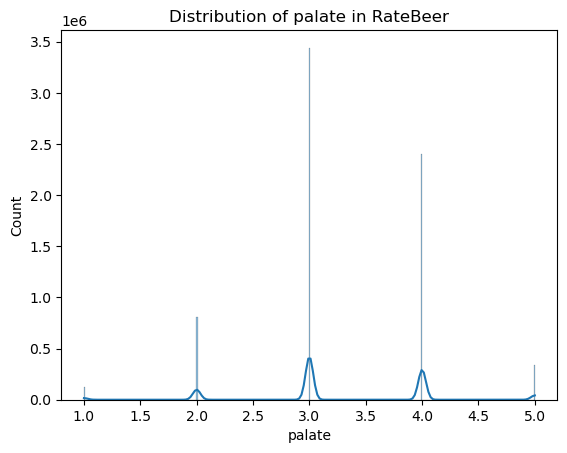

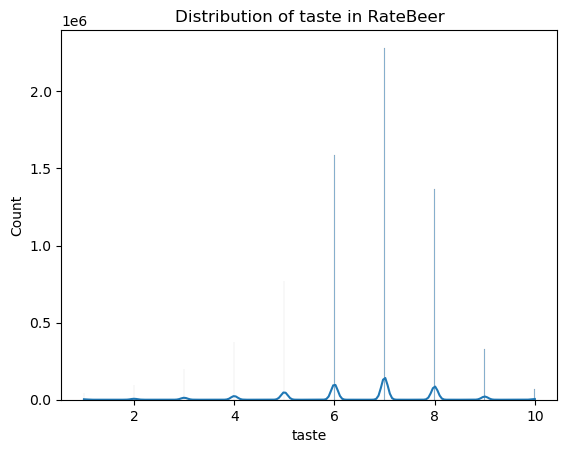

In [59]:
# perform linear regression between attribute ratings the final rating for all countries together and compare coefficients for each attribute
# perform linear regression between attribute ratings the final rating for the different countries separately and observe the distribution of the coefficients for the different attributes across countries

# Don't forget to do these kind of analysis also after merging the two different dataframes from different files
# Firstly we visualize the distrubtion of the ratings for different  beer attributes
attributes = ['appearance', 'aroma', 'palate', 'taste']  #
for col in attributes:
    plt.figure()
    sns.histplot(ba_ratings_[col], kde=True)
    plt.title(f"Distribution of {col} in Beer Advocate")
for col in attributes:
    plt.figure()
    sns.histplot(rb_ratings_[col], kde=True)
    plt.title(f"Distribution of {col} in RateBeer")

Correlation matrix:
             appearance     aroma    palate     taste
appearance    1.000000  0.660368  0.668035  0.640431
aroma         0.660368  1.000000  0.709748  0.778581
palate        0.668035  0.709748  1.000000  0.799877
taste         0.640431  0.778581  0.799877  1.000000
Correlation matrix:
             appearance     aroma    palate     taste
appearance    1.000000  0.474875  0.548253  0.483462
aroma         0.474875  1.000000  0.565140  0.793550
palate        0.548253  0.565140  1.000000  0.654290
taste         0.483462  0.793550  0.654290  1.000000


Text(0.5, 1.0, 'Correlation Matrix of different attributes in Rate Beer')

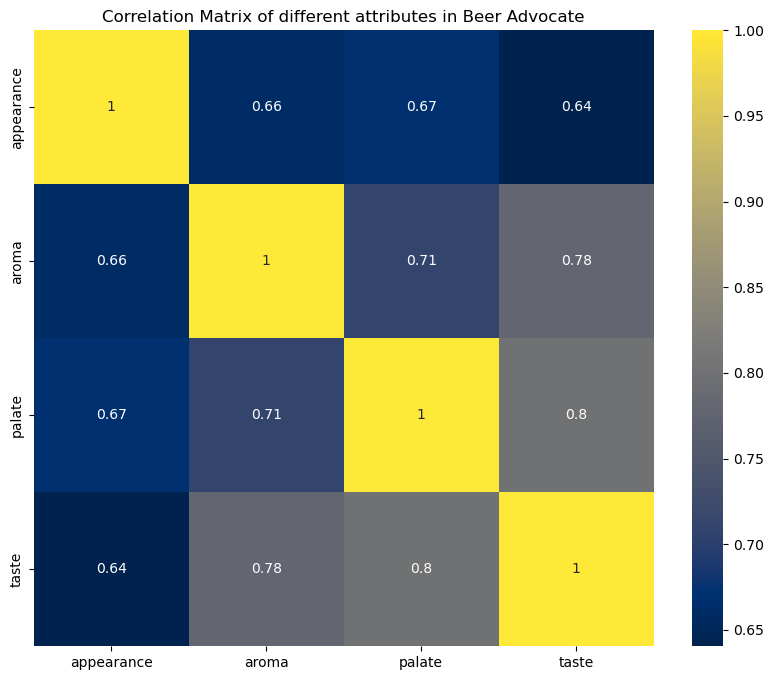

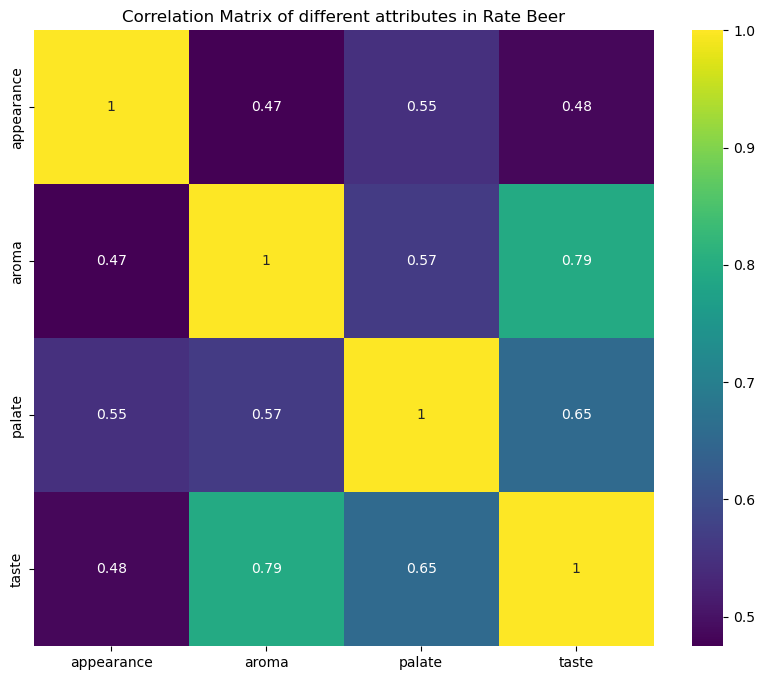

In [60]:
# We will try to see and compare how each attributes correlates between each other 
correlation_matrix_1 = ba_ratings_[attribute_columns].corr()
print("Correlation matrix:\n", correlation_matrix_1)

# Creating the plot of the correlation matrix for both data 
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="cividis")
plt.title("Correlation Matrix of different attributes in Beer Advocate")

correlation_matrix_2 = rb_ratings_[attribute_columns].corr()
print("Correlation matrix:\n", correlation_matrix_2)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_2, annot=True, cmap="viridis")
plt.title("Correlation Matrix of different attributes in Rate Beer")
plt.show()

# As we see from the plots and correlation matrix the different attributes of the beers generally correlates. The biggest correlation is between the palate and taste which is logical because the beers with richest palate tends to taste better.

# 2) Location-related biases in ratings

## a) Cultural biases

In [54]:
# determine the final rating for each country/ geographic area
# determine if the final rating for each country/ geographic area is the same using statistical tests

## b) Beer origin bias

In [55]:
# compare the final rating of domestic vs foreign beers and determine if there is a significant difference using statistical tests
# determine if the final rating of a given beer is correlated with the number of reviewers from the country where the beer comes from who reviewed that beer (scatter plot + Pearson’s correlation coefficient + regression)
# isolate beer enthusiasts (who wrote a very large number of reviews) and compare the final rating of domestic vs foreign beers and determine if there is a significant difference using statistical tests

# 3) Other biases

## a) Seasonal biases

In [50]:
# use the time information to determine the season during which each rating was posted (only consider countries with 4 seasons)
# group ratings by season
# within each group, determine the average final rating of each beer style
# compare the results for the different seasons

## b) Experience biais

In [51]:
# isolate users who gave a lot of ratings (based on a chosen threshold)
# for each user, sort their reviews chronologically and assign an "experience level" (predefined values that will be the same for all users: n<o<p) to each rating based the count of reviews posted by that user up to that rating: new reviewer (for the first n reviews), amateur (for the n+1 th review up to the oth review), expert (for the o+1 th review until the last review)
# calculate the average final rating for each experience level across all users
# represent results as a bar plot
# if a particular trend is visible,perform a paired t-test (for early vs. late reviews by the same user) to test if the rating decrease or increase is statistically significant